# URL:https://www.kaggle.com/code/cdeotte/xgboost-starter-ensemble-lb-0-935-wow

# XGBoost Starter Notebook - LB Ensemble 0.933! Wow!
In this notebook, we train an XGBoost model and ensemble it with the best public notebook. The best public notebook achieves `LB = 0.915` and our ensemble achieves `LB = 0.935` Wow!

# UPDATE
In version 2 we increase `max_depth` from `3` to `6` to allow for more feature interaction and we add regularation `alpha=1` to prevent overifitting which improves generalization to LB test data. This improves ensemble LB score `LB 0.926 => LB 0.935` woohoo!

# Load Data

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

train = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
print("Train shape", train.shape )
train.head()

Train shape (2190, 13)


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [2]:
test = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")
print("Test shape:", test.shape )
test.head()

Test shape: (730, 12)


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


In [3]:
RMV = ['rainfall','id']
FEATURES = [c for c in train.columns if not c in RMV]
print("Our features are:")
print( FEATURES )

Our features are:
['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']


# XGBoost
We train 5 fold XGBoost model. We use `max_depth=6`, `colsample_bytree=0.9`, and `subsample=0.9`. These are the 3 hyperparameters that i like to tune.

In [4]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor, XGBClassifier
import xgboost
print("Using XGBoost version",xgboost.__version__)

Using XGBoost version 2.0.3


In [5]:
%%time
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"rainfall"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"rainfall"]
    x_test = test[FEATURES].copy()

    model = XGBClassifier(
        device="cuda",
        max_depth=6,  
        colsample_bytree=0.9, 
        subsample=0.9, 
        n_estimators=10_000,  
        learning_rate=0.1, 
        eval_metric="auc",
        early_stopping_rounds=100,
        alpha=1,
    )
    model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=100 
    )

    # INFER OOF
    oof_xgb[test_index] = model.predict_proba(x_valid)[:,1]
    # INFER TEST
    pred_xgb += model.predict_proba(x_test)[:,1]

# COMPUTE AVERAGE TEST PREDS
pred_xgb /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-auc:0.84676
[100]	validation_0-auc:0.86452
[137]	validation_0-auc:0.86173
#########################
### Fold 2
#########################
[0]	validation_0-auc:0.86691


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:25:26] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[100]	validation_0-auc:0.87036
[117]	validation_0-auc:0.86668
#########################
### Fold 3
#########################
[0]	validation_0-auc:0.86882
[100]	validation_0-auc:0.90438
[200]	validation_0-auc:0.89831
[202]	validation_0-auc:0.89839
#########################
### Fold 4
#########################
[0]	validation_0-auc:0.91471
[100]	validation_0-auc:0.91840
[101]	validation_0-auc:0.91840
#########################
### Fold 5
#########################
[0]	validation_0-auc:0.85718
[100]	validation_0-auc:0.87551
[132]	validation_0-auc:0.87400
CPU times: user 2.52 s, sys: 251 ms, total: 2.77 s
Wall time: 2.68 s


In [6]:
from sklearn.metrics import roc_auc_score
true = train.rainfall.values
m = roc_auc_score(true, oof_xgb)
print(f"XGBoost CV Score AUC = {m:.3f}")

XGBoost CV Score AUC = 0.861


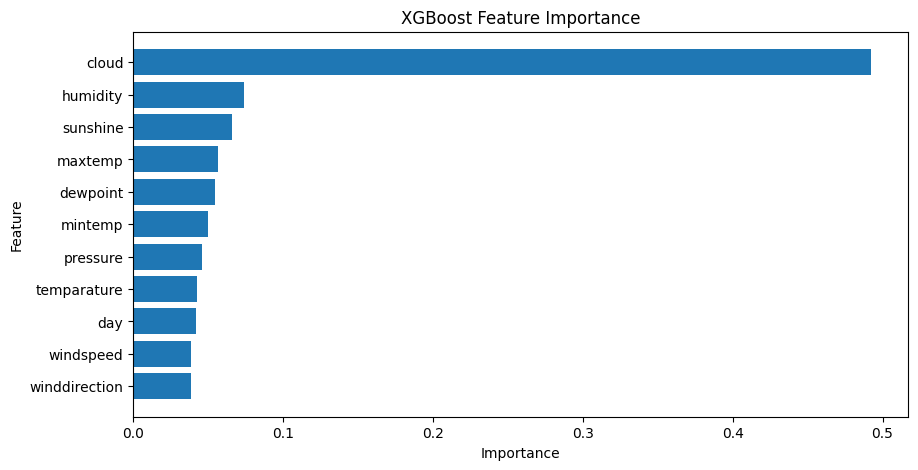

In [7]:
feature_importance = model.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  
plt.show()

# Submission CSV Ensemble!
We load the best public notebook from version 17 of public notebook which achieves `LB 0.915` (from [here][1]). Then we ensemble our new XGBoost model preditions with weights `-1.0 * XGB + 2.0 * Public`. We use `scipy.stats.rankdata` to normalize predictions before ensemble. We achieve `LB 0.935` hooray!

[1]: https://www.kaggle.com/code/act18l/auc-post-processing?scriptVersionId=227652340

In [8]:
print("Best Public Notebook achieves LB = 0.915!")
best_public = pd.read_csv("/kaggle/input/lb-915-public-notebook/submission.csv")
display( best_public.head() )
best_public = best_public.rainfall.values

Best Public Notebook achieves LB = 0.915!


,id,rainfall
0,2190,0.978408
1,2191,0.983057
2,2192,0.812125
3,2193,0.160289
4,2194,0.091565


In [9]:
from scipy.stats import rankdata

print("Ensemble achieves LB = 0.935! Hooray!")
sub = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
sub.rainfall = -1 * rankdata( pred_xgb ) + 2 * rankdata( best_public )
sub.rainfall = rankdata( sub.rainfall ) / len(sub)
print( sub.shape )
sub.to_csv(f"submission_ensemble.csv",index=False)
sub.head()

Ensemble achieves LB = 0.935! Hooray!
(730, 2)


,id,rainfall
0,2190,0.877397
1,2191,0.928767
2,2192,0.281507
3,2193,0.084932
4,2194,0.019863
